## Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 0- Read Data

In [7]:
demands= pd.read_csv("g 4_demands.csv" ,  names=["Demand"])
demands

,Demand
0,3
1,12
2,17
3,13
4,9
...,...
95,11
96,6
97,1
98,16


In [8]:
customer_locs = pd.read_csv("g 4_coordinates.csv" , names=["x1", "x2"])
customer_locs

,x1,x2
0,92,54
1,30,59
2,67,51
3,0,92
4,65,90
...,...,...
95,70,29
96,68,94
97,5,49
98,54,27


In [9]:
cost_matrix= pd.read_csv("g 4_costs.csv", names=['F'+str(i) for i in range(1,11)])
cost_matrix

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
0,5,4,8,9,3,1,6,5,4,5
1,8,2,6,4,8,2,6,10,10,7
2,9,4,4,7,8,5,4,5,4,9
3,1,3,7,7,1,1,8,8,9,4
4,1,2,7,3,9,5,5,4,9,1
...,...,...,...,...,...,...,...,...,...,...
95,3,5,5,1,1,9,7,8,3,8
96,4,8,9,6,8,2,2,9,1,3
97,1,2,8,2,7,6,7,7,1,10
98,3,6,6,10,7,8,9,8,3,4


## 1- Single Facility with Squared Euclidean distance

In [43]:
def single_facility_squared_euc(facility_no): 
    
    # obj func = sum(C_ij * d(X, a_j))
    # C_j = h_j * c_j gives you the total cost of assigning facility i to customer j per unit distance
    
    # Solving the obj func yields:
    # X = sum_over_j(C_j*a_j) / sum_over_j(C_j*h_j)
    
    # X_1 = sum_over_j(C_j*a_1j) / sum_over_j(C_j)
    # X_2 = sum_over_j(C_j*a_2j) / sum_over_j(C_j)
    
    C_j = cost_matrix["F"+str(facility_no)] * demands["Demand"]
    
    X_1 = sum(C_j * customer_locs["x1"] ) / sum(C_j)
    X_2 = sum(C_j * customer_locs["x2"] ) / sum(C_j)
    
    return (X_1, X_2)

In [44]:
facility_no = 6 #choose facility randomly to demonstrate the alg.
single_facility_squared_euc(facility_no)

(55.38975662913185, 51.29985470395932)

## 2- Single Facility with Euclidean distance

In [45]:
C = cost_matrix * demands.values

## 3- Multi Facility with Squared Euclidean distance

In [46]:
def single_facility_squared_euc_vectorized(C, A): 
    #C = h * c gives you the total cost of assigning facility i to customer j per unit distance
    #A is the customer locations
    
    #vectorized version of single facility squared euclidean problem solution.
    X = (C.T @ A) / np.sum(C.values, axis = 0, keepdims=True).T
    
    return (X)

In [47]:
def calculate_squared_euclidean_dist(x,y):
    diff = x - y
    dist = diff @ diff
    return(dist)

In [48]:
def squared_euclidean_distance_matrix(X, A):
    m = len(X.index) #number of facilities
    n = len(A.index) #number of customers
    
    D = np.zeros((m,n))
    
    for i in range(m):
        for j in range(n):
            D[i,j] = calculate_squared_euclidean_dist(X.iloc[i,], A.iloc[j,])    
    
    return(D)

In [49]:
def multi_facility_squared_euc(C, A):
    #C gives the total cost of assigning facility i to customer j per unit distance
    #A is the customer locations
    
    m = len(C.columns) #number of facilities
    n = len(A.index) #number of customers
    
    #split customers into facilities randomly for the initilization
    S = np.array_split(np.random.permutation(n),m) 
    
    #Create X dataframe to store the locations of the facilities 
    X = pd.DataFrame({'x1':np.zeros(m),'x2':np.zeros(m)})
    
    max_it = 50 ## max iteration set to 50, however; this limit is almost impossible to reach since obj. value would converge faster
    old_objective = -1 ## pseudo objective value for initialization
    
    for it in range(max_it):
        
        #solve m single facility problem
        #assign facility locations
        for i in range(m):
            #if no customer is assigned to facility i, put facility i on top of a random customer
            if len(S[i]) == 0:
                X.iloc[i,] = A.iloc[np.random.randint(0,n),]
            #proceed normally otherwise
            else: 
                Ci = C.iloc[S[i],i] #costs between facility i and customers of facility i
                Ai = A.iloc[S[i],] #customers of facility i
                X.iloc[i,] = single_facility_squared_euc_vectorized(Ci, Ai)
            
        #calculate distances
        D = pd.DataFrame(squared_euclidean_distance_matrix(X, A))
        
        #calculate objective value
        objective = 0
        for i in range(m):
            Di = D.iloc[i,S[i]] #distance between facility i and customers of facility i
            Ci = C.iloc[S[i],i] #costs between facility i and customers of facility i
            objective += Di @ Ci
        
        #stop if no progress
        if old_objective == objective:
            break
        old_objective = objective #record objective for next iteration
        
        #Reallocate customers to facilities 
        S = [[] for _ in range(m)]
        for j in range(n):
            i = np.argmin(D.iloc[:,j]) #find closest facility to customer j
            S[i].append(j)
        
        #print to debug
        debug = False
        if debug:
            print('objective function:',objective)
            print(X)
            plt.scatter(A.iloc[:,0], A.iloc[:,1], s=10)
            plt.scatter(X.iloc[:,0], X.iloc[:,1], s=50)
            plt.show()
            print(S)
            print('++++++++++++++++++++++++++++')
        
        
    return((X, objective))

In [50]:
C = cost_matrix * demands.values
np.random.seed(0) ## random seet initialized for the first allocation
X, obj = multi_facility_squared_euc(C, customer_locs)

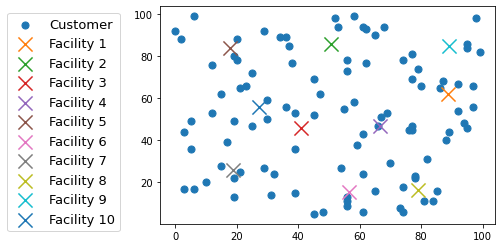

Objective value :  756691.8069197151


,x1,x2
0,88.887978,61.893443
1,50.519897,86.023107
2,40.939850,45.857143
3,66.550796,46.603427
4,17.790948,84.125000
5,56.653920,15.541109
6,18.720430,25.786738
7,78.876437,16.497126
8,88.996933,84.865031
9,27.369205,55.801325


In [52]:
plt.scatter(customer_locs.iloc[:,0], customer_locs.iloc[:,1], s = 50, label='Customer')
for i in range(0,len(X)):  
    plt.scatter(X.iloc[i,0],X.iloc[i,1], s=200,marker='x',label='Facility '+str(i+1))

plt.legend(bbox_to_anchor=(-0.10,1), prop={'size': 13})
plt.show()
print('Objective value : ',obj)
X

In [14]:
import time

In [16]:
np.random.seed(0)
X_list = []
obj_list = []
time_list = []

n_trials = 1000
for i in range(n_trials):
    start_time = time.time()
    X, obj = multi_facility_squared_euc(C, customer_locs)
    X_list.append(X)
    obj_list.append(obj)
    time_list.append(time.time() - start_time)
    if (i+1)%5==0:
        print('iteration' + str(i+1))
        print(np.mean(time_list))


iteration5
1.0718980789184571
iteration10
1.2753478050231934
iteration15
1.3283644199371338
iteration20
1.2880728006362916
iteration25
1.3376777362823487
iteration30
1.310481103261312
iteration35
1.3049120766775948
iteration40
1.2914082527160644
iteration45
1.283397881189982
iteration50
1.2638797044754029
iteration55
1.241100636395541
iteration60
1.2622015913327536
iteration65
1.2518461887653058
iteration70
1.2484036377498082
iteration75
1.2479979228973388
iteration80
1.2326515465974808
iteration85
1.2404777751249425
iteration90
1.2605361567603217
iteration95
1.2491025849392539
iteration100
1.2469923520088195
iteration105
1.2447640487125942
iteration110
1.254770116372542
iteration115
1.2643539200658385
iteration120
1.2775265554587045
iteration125
1.2849653930664062
iteration130
1.2900204731867864
iteration135
1.288397416362056
iteration140
1.2916688510349819
iteration145
1.2984250101549872
iteration150
1.296880768140157
iteration155
1.2884039140516712
iteration160
1.2849037289619445
it

In [ ]:
np.mean(X_list, axis=0)

NameError: name 'X_list' is not defined

In [24]:
np.mean(obj_list)

827083.7791937701

In [29]:
best_idx = np.argmin(obj_list)

In [30]:
X_list[best_idx]

,x1,x2
0,55.069159,12.392523
1,40.148760,51.403581
2,78.434615,16.792308
3,17.968825,59.122302
4,86.609062,74.476291
5,24.357143,82.736607
6,83.848077,46.471154
7,59.026639,90.684426
8,15.392461,20.962306
9,62.860082,49.802469


In [31]:
best_idx = np.argmin(obj_list)
obj_list[best_idx]

604947.8915668012